# Simulation example
This example illustrates how to use the simulation functionality of this package, i.e., the exp_decay_probs and normal_exp_decay_calib functions.

We work with FAANG stocks from 18th of May 2012 (the first day where data is available for all five stocks) to simulate P&L based on historical time series and perform some portfolio optimizations against a S&P 500 benchmark.

The interested reader can explore this example further by, e.g., introducing Entropy Pooling views / stress-tests and work on longer horizons with less frequent rebalancing than the one day horizon we use. The analysis and differences between CVaR and variance optimization usually become more interesting on longer horizons.

You can watch a video walkthrough of the example here: https://youtu.be/tg3GMjFjH04.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [2]:
tickers = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG', '^GSPC']
data = yf.download(tickers, start='2012-05-18', end='2022-11-30')
data = data['Adj Close']
data.columns = list(data.columns[:-1]) + ['S&P 500']
data.head()

[*********************100%%**********************]  6 of 6 completed


,AAPL,AMZN,GOOG,META,NFLX,S&P 500
Date,,,,,,
2012-05-18,16.056866,10.6925,14.953949,38.230000,9.994286,1295.219971
2012-05-21,16.992344,10.9055,15.295419,34.029999,10.248571,1315.989990
2012-05-22,16.861864,10.7665,14.963912,31.000000,9.672857,1316.630005
2012-05-23,17.273293,10.8640,15.179603,32.000000,10.272857,1318.859985
2012-05-24,17.114653,10.7620,15.035145,33.029999,10.038571,1320.680054


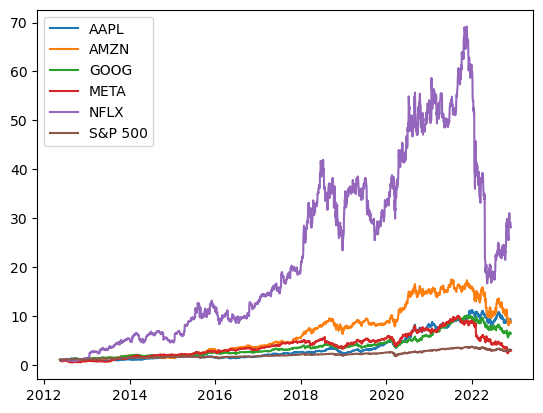

In [3]:
plt.plot(data / data.iloc[0, :])
plt.legend(data.columns)
plt.show()

In [4]:
data_np = data.values
R_np = data_np[1:] / data_np[:-1] - 1
R = pd.DataFrame(R_np, columns=data.columns)
T, I = R.shape

hist_stats = ft.simulation_moments(R)
hist_stats.iloc[:, 0:2] = hist_stats.iloc[:, 0:2].mul(100)
np.round(hist_stats, 3)

,Mean,Volatility,Skewness,Kurtosis
AAPL,0.099,1.827,-0.127,8.607
AMZN,0.102,2.031,0.292,9.930
GOOG,0.084,1.684,0.479,11.954
META,0.072,2.521,-0.014,23.383
NFLX,0.174,3.092,0.724,29.815
S&P 500,0.048,1.093,-0.546,18.517


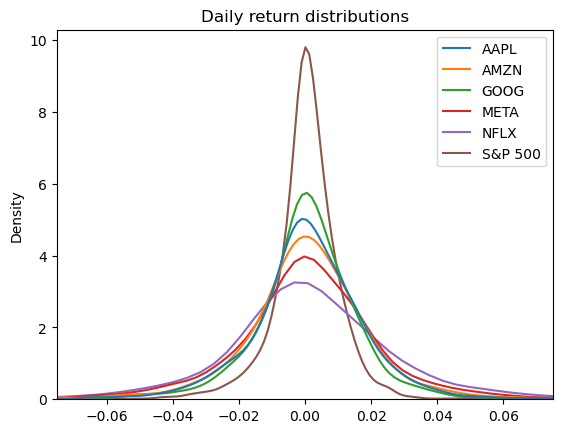

In [5]:
sns.kdeplot(R)
plt.xlim([-0.075, 0.075])
plt.title('Daily return distributions')
plt.show()

# Historical portfolio optimization
We first optimize portfolios with the historical scenarios as well as mean and covariance matrix.

In [6]:
hist_mean = np.mean(R.values, axis=0)
hist_cov = ft.covariance_matrix(R).values

In [7]:
G = np.vstack((np.eye(I), -np.eye(I)))
h = np.hstack((np.ones(I), np.hstack((np.ones(I - 1), [-1]))))
return_target = np.mean(hist_stats['Mean'] / 100)

hist_cvar = ft.MeanCVaR(R.values, G, h)
hist_var = ft.MeanVariance(hist_mean, hist_cov, G, h)
pf_cvar = hist_cvar.efficient_portfolio(return_target)
pf_var = hist_var.efficient_portfolio(return_target)
hist_results = np.hstack((pf_cvar, pf_var))

In [8]:
hist_results_df = pd.DataFrame(
    hist_results, index=R.columns, columns=['CVaR', 'Variance'])
np.round(hist_results_df, 3)

,CVaR,Variance
AAPL,-0.006,0.146
AMZN,-0.029,0.069
GOOG,-0.242,-0.395
META,-0.236,-0.282
NFLX,0.512,0.462
S&P 500,1.000,1.000


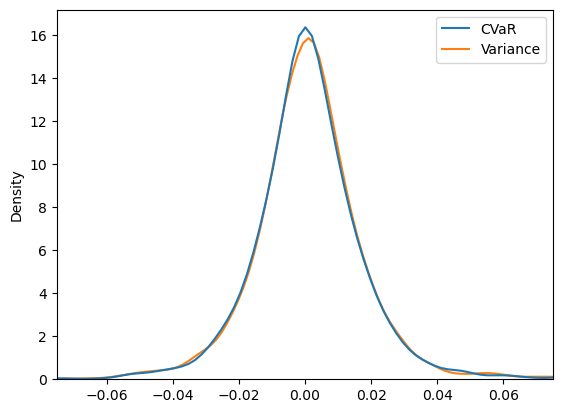

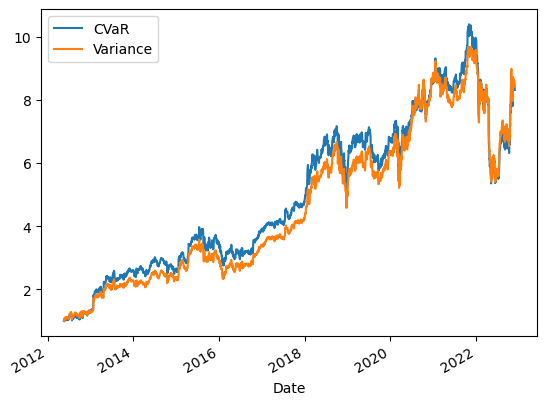

In [9]:
# Historical P&L and performance with daily rebalancing
pf_pnls = R @ hist_results_df
sns.kdeplot(pf_pnls)
plt.xlim([-0.075, 0.075])

pf_perfs = np.cumprod(np.vstack((np.ones((1, 2)), pf_pnls.values + 1)), axis=0)
pf_perfs_df = pd.DataFrame(pf_perfs, index=data.index, columns=hist_results_df.columns)
pf_perfs_df.plot()
plt.show()

In [10]:
means = np.mean(pf_pnls.values, axis=0)
vols = ft.portfolio_vol(hist_results, R)
vars = ft.portfolio_var(hist_results, R)
cvars = ft.portfolio_cvar(hist_results, R)
overview = np.vstack((means, vols, vars, cvars))
display(np.round(pd.DataFrame(
    100 * overview, index=['Mean', 'Vol', 'VaR', 'CVaR'], columns=pf_perfs_df.columns), 3))

,CVaR,Variance
Mean,0.096,0.096
Vol,1.810,1.780
VaR,2.514,2.569
CVaR,4.015,4.103


# Exponentially decaying scenario probabilities
The above analysis uses the historical data as is. If we want to give more weight to recent data, we can use exponential smoothing of the historical scenario probabilities. We can use these exponentially decaying probabilities directly, e.g., in CVaR optimization and for Entropy Pooling views / stress-testing.

Alternatively, we can use them to calibrate a mean vector and a covariance matrix for mean-variance analysis. The mean vector and covariance matrix can also be used to generate normally distributed simulations if one wishes to increase the sample size, while restricting the distribution to being multivariate normal. We do not recommend these approaches or using mean-variance optimization / analysis in general due to the oversimplifying assumption the normal distribution imposes, see https://ssrn.com/abstract=4034316. Hence, if you wish to increase the sample size by generating new synthetic scenarios, we recommend that you use more sophisticated methods than a simple multivariate normal calibration. If you are an institutional investor and want to know more, please contact us for a dialog about our Investment Simulation module.

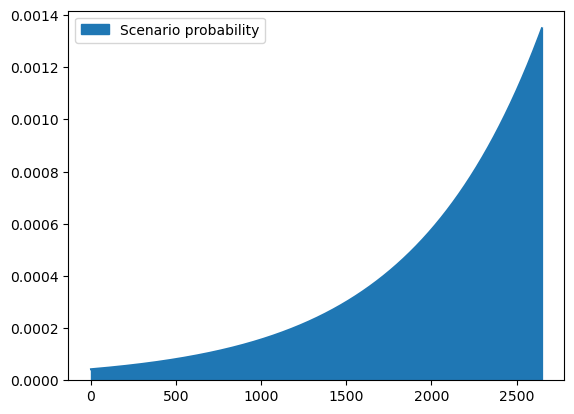

In [11]:
p = ft.exp_decay_probs(R, T / 5)
pd.DataFrame(p, columns=['Scenario probability']).plot(kind='area')
plt.show()

In [12]:
# Illustrating the effect of the half life paramter
print(p[int(-(T / 5 + 1))] / p[-1])
print(p[int(-(2 * T / 5 + 1))] / p[int(-(T / 5 + 1))])

[0.5]
[0.5]


In [13]:
# Mean and covariance matrix calibration
exp_mean, exp_cov = ft.normal_exp_decay_calib(R, T / 5)

In [14]:
# Relation between exp_mean, exp_cov and p
stats_exp_decay = ft.simulation_moments(R, p)
cov_matrix_exp_decay = ft.covariance_matrix(R, p)
print('Mean comparison:')
display(stats_exp_decay['Mean'] - exp_mean['Mean'])
print('Covariance comparison:')
display(cov_matrix_exp_decay - exp_cov)

Mean comparison:


AAPL       0.0
AMZN       0.0
GOOG       0.0
META       0.0
NFLX       0.0
S&P 500    0.0
Name: Mean, dtype: float64

Covariance comparison:


,0,1,2,3,4,5
"(0, AAPL)",0.0,0.0,0.0,0.0,0.0,0.0
"(1, AMZN)",0.0,0.0,0.0,0.0,0.0,0.0
"(2, GOOG)",0.0,0.0,0.0,0.0,0.0,0.0
"(3, META)",0.0,0.0,0.0,0.0,0.0,0.0
"(4, NFLX)",0.0,0.0,0.0,0.0,0.0,0.0
"(5, S&P 500)",0.0,0.0,0.0,0.0,0.0,0.0


# Repeating the optimization and risk analysis
With the new exponentially decaying probabilities at hand, we can repeat the optimization analysis.

In [15]:
exp_cvar = ft.MeanCVaR(R.values, G, h, p=p)
exp_var = ft.MeanVariance(exp_mean.values[:, 0], exp_cov.values, G, h)
pf_exp_cvar = exp_cvar.efficient_portfolio(return_target)
pf_exp_var = exp_var.efficient_portfolio(return_target)
exp_results = np.hstack((pf_exp_cvar, pf_exp_var))

In [16]:
exp_results_df = pd.DataFrame(
    exp_results, index=R.columns, columns=['CVaR', 'Variance'])
np.round(exp_results_df, 3)

,CVaR,Variance
AAPL,0.365,0.438
AMZN,-0.231,-0.221
GOOG,0.203,0.093
META,-0.456,-0.417
NFLX,0.119,0.106
S&P 500,1.000,1.000


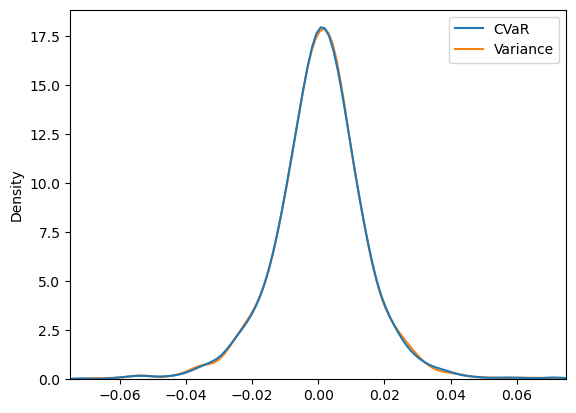

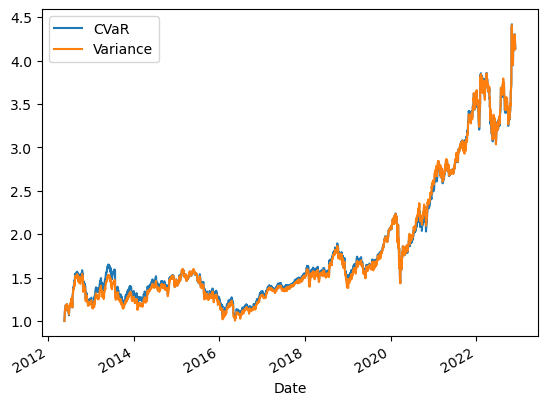

In [17]:
# Historical performance with daily rebal
pf_pnls2 = R @ exp_results_df
sns.kdeplot(pf_pnls2)
plt.xlim([-0.075, 0.075])

pf_perfs2 = np.cumprod(np.vstack((np.ones((1, 2)), pf_pnls2.values + 1)), axis=0)
pf_perfs_df2 = pd.DataFrame(pf_perfs2, index=data.index, columns=hist_results_df.columns)
pf_perfs_df2.plot()
plt.show()

In [18]:
means2 = p.T @ pf_pnls2.values
vols2 = ft.portfolio_vol(exp_results, R, p=p)
vars2 = ft.portfolio_var(exp_results, R, p=p)
cvars2 = ft.portfolio_cvar(exp_results, R, p=p)
overview2 = np.vstack((means2, vols2, vars2, cvars2))
display(np.round(pd.DataFrame(
    100 * overview2, index=['Mean', 'Vol', 'VaR', 'CVaR'], columns=pf_perfs_df.columns), 3))

,CVaR,Variance
Mean,0.096,0.096
Vol,1.640,1.632
VaR,2.457,2.442
CVaR,3.614,3.623


# Comments on results
With daily returns and rebalancing, the return target becomes a dominant constraint. Hence, there is not much difference between the CVaR and variance optimized portfolios for this limited investment universe. On longer horizons, the nuances become more interesting. The interested reader is encouraged to adjust the code and work with, for example, monthly returns and rebalancing in addition to introducing Entropy Pooling views / stress-testing.

# Final comments
In this example, we perform optimizations with a return target. For real-world applications, the optimizations should most likely be performed subject to a risk budget on overall portfolio risk as well as (CVaR) tracking error as explained in https://ssrn.com/abstract=4034316. Solving these kinds of problems (especially for CVaR) is significantly harder and is not a part of our open-source package. If you are an institutional investor and want to solve these kinds of problems including transaction costs, parameter uncertainty and advanced constraints, please contact us for a demo of our proprietary solutions by sending an email to demo@fortitudo.tech.

# License

In [19]:
# fortitudo.tech - Novel Investment Technologies.
# Copyright (C) 2021-2024 Fortitudo Technologies.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.